In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import re
import joblib
from preprocess import pfeature_process
from seq_cleanup import clean_seq
from network import create_model
import csv
import torch
import yaml
import subprocess
from pepfunn.sequence import Sequence

In [28]:
seqs = pd.read_csv('../data/processed/generated_seqs_len30.csv')
seqs


,sequences
0,NTICINNEQSVYGTYNQIKVKSEGKWWQIY
1,QHTTNQTSQVQLDTGWQQHSTLYKEGDATF
2,RQLWARCKIPLISVKFYKSNMSNMITKFRR
3,GRPYEHRDGNVAFDPTSLLLVAMMLGQIWL
4,DCCACVCGAAGQKXHHRGTEFRVWWPEFVW
...,...
2995,NNIYCDRSRIHPWLGNHWWWWGNRFCHLGT
2996,TKEMGEMVIGQMGKNYPSTYMPMPIKFAPV
2997,LIPFEYDVNFAQIYFVKDMWFPPDFARIQD
2998,ERDCKYPFFCYVLGTPVEYDEWTIATCSKV


In [29]:
print(type(seqs))
print(seqs.columns)


In [30]:
#Clean up seceuences, uppercase, remove invalid chars, remove X from begging and end of sequence
#remove sequences with intermediary Xs
filtered_df = clean_seq(seqs)
filtered_df

,sequences
0,NTICINNEQSVYGTYNQIKVKSEGKWWQIY
1,QHTTNQTSQVQLDTGWQQHSTLYKEGDATF
2,RQLWARCKIPLISVKFYKSNMSNMITKFRR
3,GRPYEHRDGNVAFDPTSLLLVAMMLGQIWL
4,DEDIGGVLCARVQSTPQWRCDYSRASNMSR
...,...
2569,HCQNSYKWPHSKIKSNHSFKHPWYHFHPR
2570,EDYPNNNIGDYWTWMCSITPVYDWMTVPW
2571,DLNYTFGPFEMTPSECCWMSMYYCQGGEM
2572,RKYLERQIYCLTLDFASLISSCTFKSYGF


In [31]:
#Convert cleaned dataframe to Fasta format
with open('../data/interim/filtered_seqs.fasta','w', encoding='UTF8') as f:
    
    for i in range(len(filtered_df)):
        f.write(f">{i}\n{filtered_df.iloc[i,0]}\n")

In [32]:
cd_hit_path = "../data/interim/filtered_seqs_cd_hit.txt"

In [33]:
# Process sequences with CD-HIT using WSL on windows environment
# Ensure that WSL is installed and CD-HIT is available in the WSL environment
command = ["wsl", "cd-hit", "-i", "../data/interim/filtered_seqs.fasta", "-o", cd_hit_path, "-c", "0.99"]

# Run the command
result = subprocess.run(command, capture_output=True, text=True)

# Print the output and errors
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)

In [35]:
processed_seqs = pfeature_process(cd_hit_path,'../data/processed/pre_processed_seqs_pfeature.csv')
processed_seqs

,PCP_PC,PCP_NC,PCP_NE,PCP_PO,PCP_NP,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,...,RRI_M,RRI_N,RRI_P,RRI_Q,RRI_R,RRI_S,RRI_T,RRI_V,RRI_W,RRI_Y
NTICINNEQSVYGTYNQIKVKSEGKWWQIY,-0.519221,-0.671459,0.896775,1.446152,-0.989455,-0.434948,-1.150966,0.299387,-0.671459,-0.519221,...,-1.287440,1.221939,-1.585613,0.574607,-1.653530,0.275325,0.211055,0.368116,2.404459,0.351825
QHTTNQTSQVQLDTGWQQHSTLYKEGDATF,-0.519221,-0.169091,0.548744,3.028260,-1.572768,-1.102796,-1.150966,-0.617816,-0.169091,-0.519221,...,-1.287440,0.193054,-1.585613,1.175330,-1.653530,0.275325,0.922260,0.368116,0.549339,0.351825
RQLWARCKIPLISVKFYKSNMSNMITKFRR,1.600543,-1.691419,-0.157863,-0.147852,-0.105648,-0.434948,-0.382175,-0.166060,-1.691419,1.600543,...,0.568712,0.193054,0.400954,0.574607,1.355045,0.275325,0.211055,0.368116,0.549339,0.351825
GRPYEHRDGNVAFDPTSLLLVAMMLGQIWL,-0.519221,-0.169091,0.548744,-1.337407,1.661967,1.887567,0.409913,-0.617816,-0.169091,-0.519221,...,2.424864,0.193054,0.400954,0.574607,0.352187,0.275325,0.211055,0.368116,0.549339,0.351825
DEDIGGVLCARVQSTPQWRCDYSRASNMSR,-0.100345,0.333277,-0.157863,1.041703,-0.688960,-0.106009,-0.382175,-1.069573,0.333277,-0.100345,...,0.568712,0.193054,0.400954,0.574607,0.352187,0.275325,0.211055,0.368116,0.549339,0.351825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HCQNSYKWPHSKIKSNHSFKHPWYHFHPR,3.022180,-1.691419,-1.339058,0.363657,-1.493225,-1.720804,1.248595,0.846971,-1.691419,3.022180,...,-1.287440,0.193054,0.400954,0.574607,0.352187,0.275325,-1.944110,-1.606913,0.549339,0.351825
EDYPNNNIGDYWTWMCSITPVYDWMTVPW,-1.788540,0.409394,1.202620,0.363657,0.336256,-0.345238,1.248595,1.312417,0.409394,-1.788540,...,0.568712,4.308592,0.400954,-1.245765,-1.653530,0.275325,0.211055,0.368116,0.549339,0.351825
DLNYTFGPFEMTPSECCWMSMYYCQGGEM,-1.788540,0.409394,1.202620,1.588898,0.026923,-1.033021,0.456507,0.846971,0.409394,-1.788540,...,0.568712,0.193054,0.400954,0.574607,-1.653530,0.275325,0.211055,-1.606913,0.549339,1.718995
RKYLERQIYCLTLDFASLISSCTFKSYGF,-0.036879,-0.641013,0.474920,2.005243,-0.582904,-0.345238,-1.150966,0.846971,-0.641013,-0.036879,...,-1.287440,-1.864715,-1.585613,0.574607,0.352187,1.324034,0.211055,-1.606913,-1.305781,0.351825


In [36]:
#ubicacion de los archivos de datos con el modelo y el archivo FASTA procesado con CD-HIT
model_path = '../models/dtr_model.pkl'
pre_processed_seqs_path = '../data/processed/pre_processed_seqs_pfeature.csv'
positive_seqs_path = '../data/processed/positve_sequences.csv'
pre_processed_seqs = pd.read_csv(pre_processed_seqs_path, index_col=0)
pre_processed_seqs

,PCP_PC,PCP_NC,PCP_NE,PCP_PO,PCP_NP,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,...,RRI_M,RRI_N,RRI_P,RRI_Q,RRI_R,RRI_S,RRI_T,RRI_V,RRI_W,RRI_Y
Sequence,,,,,,,,,,,,,,,,,,,,,
NTICINNEQSVYGTYNQIKVKSEGKWWQIY,-0.519221,-0.671459,0.896775,1.446152,-0.989455,-0.434948,-1.150966,0.299387,-0.671459,-0.519221,...,-1.287440,1.221939,-1.585613,0.574607,-1.653530,0.275325,0.211055,0.368116,2.404459,0.351825
QHTTNQTSQVQLDTGWQQHSTLYKEGDATF,-0.519221,-0.169091,0.548744,3.028260,-1.572768,-1.102796,-1.150966,-0.617816,-0.169091,-0.519221,...,-1.287440,0.193054,-1.585613,1.175330,-1.653530,0.275325,0.922260,0.368116,0.549339,0.351825
RQLWARCKIPLISVKFYKSNMSNMITKFRR,1.600543,-1.691419,-0.157863,-0.147852,-0.105648,-0.434948,-0.382175,-0.166060,-1.691419,1.600543,...,0.568712,0.193054,0.400954,0.574607,1.355045,0.275325,0.211055,0.368116,0.549339,0.351825
GRPYEHRDGNVAFDPTSLLLVAMMLGQIWL,-0.519221,-0.169091,0.548744,-1.337407,1.661967,1.887567,0.409913,-0.617816,-0.169091,-0.519221,...,2.424864,0.193054,0.400954,0.574607,0.352187,0.275325,0.211055,0.368116,0.549339,0.351825
DEDIGGVLCARVQSTPQWRCDYSRASNMSR,-0.100345,0.333277,-0.157863,1.041703,-0.688960,-0.106009,-0.382175,-1.069573,0.333277,-0.100345,...,0.568712,0.193054,0.400954,0.574607,0.352187,0.275325,0.211055,0.368116,0.549339,0.351825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HCQNSYKWPHSKIKSNHSFKHPWYHFHPR,3.022180,-1.691419,-1.339058,0.363657,-1.493225,-1.720804,1.248595,0.846971,-1.691419,3.022180,...,-1.287440,0.193054,0.400954,0.574607,0.352187,0.275325,-1.944110,-1.606913,0.549339,0.351825
EDYPNNNIGDYWTWMCSITPVYDWMTVPW,-1.788540,0.409394,1.202620,0.363657,0.336256,-0.345238,1.248595,1.312417,0.409394,-1.788540,...,0.568712,4.308592,0.400954,-1.245765,-1.653530,0.275325,0.211055,0.368116,0.549339,0.351825
DLNYTFGPFEMTPSECCWMSMYYCQGGEM,-1.788540,0.409394,1.202620,1.588898,0.026923,-1.033021,0.456507,0.846971,0.409394,-1.788540,...,0.568712,0.193054,0.400954,0.574607,-1.653530,0.275325,0.211055,-1.606913,0.549339,1.718995


In [37]:
#model loading
model = joblib.load(model_path)

c:\Users\alejandros\Documents\GitHub\accelerated_drug_discovery\.venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [38]:
#infer seqs
predict_seqs = model.predict(pre_processed_seqs)
predict_seqs

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [39]:
result_seqs = pd.DataFrame(predict_seqs)
result_seqs.index = pre_processed_seqs.index
result_seqs.reset_index(inplace=True)
result_seqs.rename(columns={'index':'Secuence', 0:'Label'}, inplace=True)
positive_seqs = result_seqs[result_seqs['Label']==1]
negative_seqs = result_seqs[result_seqs['Label']==0]
print(f'The process found {len(positive_seqs)} as positve and {len(negative_seqs)} as negative out of a total of {len(pre_processed_seqs)} sequences, representing a {((len(positive_seqs)/len(pre_processed_seqs))*100)}% of positve sequences')
positive_seqs.to_csv(positive_seqs_path, index = False)


### peptideBERT processing

In [40]:
#Model load function
def load_bert_model(feature, device):
    config = yaml.load(open(f'../models/{feature}/config.yaml', 'r'), Loader=yaml.FullLoader)
    config['device'] = device
    model = create_model(config)
    model.load_state_dict(torch.load(f'../models/{feature}/model.pt',weights_only = False)['model_state_dict'], strict=False)
    return model

In [41]:
#peptideBERT process function
def predict_peptidebert(sequences):
    peptides =sequences.copy()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    MAX_LEN = max(map(len, sequences))
    # convert to tokens
    mapping = dict(zip(
        ['[PAD]','[UNK]','[CLS]','[SEP]','[MASK]','L',
        'A','G','V','E','S','I','K','R','D','T','P','N',
        'Q','F','Y','M','H','C','W'],
        range(30)
    ))

    
    for i in range(len(sequences)):
        #print(f'seq {sequences[i]}, pos {i}')
        sequences[i] = [mapping[c] for c in sequences[i]] 
        sequences[i].extend([0] * (MAX_LEN - len(sequences[i])))  # padding to max length
    
    results = pd.DataFrame({'Sequence':peptides})
    feats = ['hemo','sol','nf']
    with torch.inference_mode():
        for c in feats:
            print(f'Processing sequences {c} feature')
            model = load_bert_model(c,device)
            preds = []
            for i in range(len(sequences)):
                input_ids = torch.tensor([sequences[i]]).to(device)
                attention_mask = (input_ids != 0).float()
                #output = float(model(input_ids, attention_mask)[0])
                output = int(model(input_ids, attention_mask)[0] > 0.5)
                #print(f'Secuencia {peptides[i]} {c]: {output}')
                preds.append(output)
                
            results = pd.concat([results,pd.DataFrame(preds, columns = [c]).astype(int)], axis=1)
    
    results.to_csv(f'../data/peptideBert_results.csv', index=False)
    return results

In [42]:

pos_seqs ='../data/processed/positve_sequences.csv' 
pos_seqs

'../data/processed/positve_sequences.csv'

In [43]:
seqs = []
with open(pos_seqs) as fp:
    next(fp)
    f = csv.reader(fp, delimiter = ',', quotechar='"')
    for line in f:
        seq = line[0].strip()
        #seq = re.sub(r'[\'\"\[\]]','',str(line)).strip()
        seqs.append(seq)

In [44]:
bert_results = predict_peptidebert(seqs)

In [45]:
bert_results = pd.read_csv('../data/peptideBert_results.csv')

In [46]:
#select non-Hemolytic peptides
non_hemolytic = bert_results[bert_results['hemo']==0]
non_hemolytic

,Sequence,hemo,sol,nf
0,NTICINNEQSVYGTYNQIKVKSEGKWWQIY,0,1,0
1,DEDIGGVLCARVQSTPQWRCDYSRASNMSR,0,1,0
2,NDGAYNGDRDSTMQRPKTYWGQIRPYYNQT,0,1,0
3,EWHWIAMNFWIELFPQDVPWKLLRLAKVQT,0,1,0
4,GLNEDEDRRQCHRKPVETEALVLVAMASPM,0,1,0
...,...,...,...,...
735,YSCPQPTCQGNHHCLQIRCCTWLWTFTTP,0,1,0
736,RNCWIFTYKYFKVKWWEFLSERVIQNVNQ,0,1,0
737,HKGPSCEYGITDNCPNNTQHLPYNCPPRF,0,1,0
738,NKIENRWDFLKLLWDNDDLPTLIDMNFSY,0,0,0


In [47]:
def pepfunn_check (df):
    """
    Analiza las secuencias de péptidos y agrega las propiedades calculadas al DataFrame.
    
    Parameters:
    df (DataFrame): DataFrame con una columna 'Sequence' que contiene las secuencias de péptidos
    
    Returns:
    DataFrame: El mismo DataFrame con columnas adicionales para las propiedades calculadas
    """
    
    # Inicializar listas para almacenar los resultados
    net_charges = []
    avg_hydros = []
    iso_points = []
    sol_rules = []
    syn_rules = []
    
    # Procesar cada secuencia
    for seq in df['Sequence']:
        pep = Sequence(seq)
        
        # Properties from the sequence
        net_charges.append(pep.netCharge)
        avg_hydros.append(pep.avg_hydro)
        iso_points.append(pep.isoelectric_point)
        
        # Empirical rules
        sol_rules.append(pep.solubility_rules_failed)
        syn_rules.append(pep.synthesis_rules_failed)
    
    # Agregar las nuevas columnas al DataFrame
    df['Net_Charge'] = net_charges
    df['Avg_Hydrophobicity'] = avg_hydros
    df['Isoelectric_Point'] = iso_points
    df['Solubility_Rules_Failed'] = sol_rules
    df['Synthesis_Rules_Failed'] = syn_rules
    
    return df
        

In [48]:
pepfunn_review = pepfunn_check(non_hemolytic)

c:\Users\alejandros\Documents\GitHub\accelerated_drug_discovery\.venv\lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


In [49]:
pepfunn_review

,Sequence,hemo,sol,nf,Net_Charge,Avg_Hydrophobicity,Isoelectric_Point,Solubility_Rules_Failed,Synthesis_Rules_Failed
0,NTICINNEQSVYGTYNQIKVKSEGKWWQIY,0,1,0,0.941596,-0.78,8.119229,2,3
1,DEDIGGVLCARVQSTPQWRCDYSRASNMSR,0,1,0,-0.087780,-7.60,6.149945,3,2
2,NDGAYNGDRDSTMQRPKTYWGQIRPYYNQT,0,1,0,0.984392,-10.84,8.377554,1,4
3,EWHWIAMNFWIELFPQDVPWKLLRLAKVQT,0,1,0,0.100669,6.06,6.857136,3,2
4,GLNEDEDRRQCHRKPVETEALVLVAMASPM,0,1,0,-1.939981,-5.54,5.007709,2,2
...,...,...,...,...,...,...,...,...,...
735,YSCPQPTCQGNHHCLQIRCCTWLWTFTTP,0,1,0,0.965662,1.77,7.848268,2,2
736,RNCWIFTYKYFKVKWWEFLSERVIQNVNQ,0,1,0,2.947650,-1.44,9.516517,3,2
737,HKGPSCEYGITDNCPNNTQHLPYNCPPRF,0,1,0,0.057500,-4.14,6.892376,2,2
738,NKIENRWDFLKLLWDNDDLPTLIDMNFSY,0,0,0,-3.010016,-1.04,4.171493,1,3


In [50]:
pepfunn_review.describe()

,hemo,sol,nf,Net_Charge,Avg_Hydrophobicity,Isoelectric_Point,Solubility_Rules_Failed,Synthesis_Rules_Failed
count,740.0,740.000000,740.0,740.000000,740.000000,740.000000,740.000000,740.000000
mean,0.0,0.878378,0.0,0.328572,-3.359473,7.255546,2.710811,2.186486
std,0.0,0.327069,0.0,3.187310,5.807317,2.283708,0.876790,0.643764
min,0.0,0.000000,0.0,-9.979559,-25.730000,4.050028,0.000000,0.000000
25%,0.0,1.000000,0.0,-1.905892,-6.902500,4.926088,2.000000,2.000000
50%,0.0,1.000000,0.0,0.289798,-3.270000,7.088698,3.000000,2.000000
75%,0.0,1.000000,0.0,2.245668,0.252500,9.310024,3.000000,3.000000
max,0.0,1.000000,0.0,9.042303,24.010000,11.999968,4.000000,4.000000


<function matplotlib.pyplot.show(close=None, block=None)>

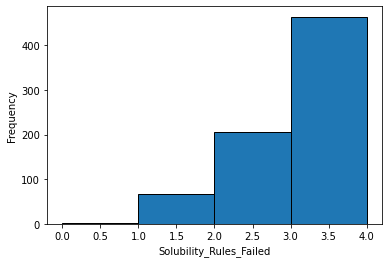

In [51]:
plt.hist(pepfunn_review['Solubility_Rules_Failed'],bins=4, edgecolor='black')
plt.xlabel('Solubility_Rules_Failed')
plt.ylabel('Frequency')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

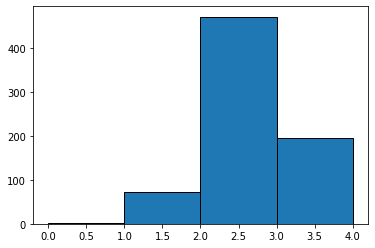

In [52]:
plt.hist(pepfunn_review['Synthesis_Rules_Failed'],bins=4, edgecolor='black')
plt.show

In [53]:
analyzed_seqs_path = '../data/processed/sequences_reviewed.csv'
pepfunn_review.to_csv(analyzed_seqs_path)

Características fisicoquímicas ideales en péptidos anti-VEGF
1. 🔋 Carga neta y punto isoeléctrico (pI)
Carga ligeramente positiva o neutra a pH fisiológico (7.4) suele favorecer la unión a VEGF (que tiene regiones cargadas negativamente) y evita interacciones no específicas con membranas celulares o proteínas plasmáticas.

pI óptimo: entre 7–9, aunque puede variar según la estrategia de entrega.

2. 💧 Hidrofobicidad / Hidrofilicidad (GRAVY Score)
Se busca un balance:

Demasiado hidrofóbico → pobre solubilidad en agua, tendencia a agregarse.

Demasiado hidrofílico → pobre permeabilidad o difusión tisular.

GRAVY (Grand Average of Hydropathy) cercano a 0 o ligeramente negativo es ideal.

Algunos residuos hidrofóbicos son necesarios para facilitar la interacción con la región de unión de VEGF (que incluye zonas no polares).

3. 🔗 Estabilidad química y proteolítica
Modificaciones recomendadas para mejorar estabilidad:

Acetilación del N-terminal y amidación del C-terminal.

Inclusión de D-aminoácidos o residuos no naturales.

Ciclos (lactamas, disulfuros, péptidos cíclicos tipo stapled peptides).

Evitar secuencias muy ricas en Arg, Lys, o Pro, que son sitios comunes de clivaje.

4. 🧬 Tamaño molecular
Generalmente entre 8–30 aminoácidos:

Más pequeños: mejor penetración y menor inmunogenicidad.

Más grandes: mayor especificidad, pero potencialmente menos estables sin modificaciones.

5. 💦 Solubilidad en agua
Fundamental para formulación y administración parenteral.

Se puede mejorar mediante:

Inclusión de residuos polares (Ser, Thr, Gln, Glu).

Conjugación con grupos hidrosolubles (PEG, cadenas laterales con OH o COOH).

6. 🧲 Potencial de agregación
Evitar regiones con tendencia a formar estructuras beta extensas o motivos tipo amyloidogenic.

Se predice mediante herramientas como TANGO, AGGRESCAN o CamSol.

7. 🌡️ Estabilidad térmica y conformacional
Debe mantenerse estructuralmente estable a temperatura fisiológica (37 °C).

Se favorece el diseño de estructuras secundarias definidas (hélices, bucles estables, ciclos).

8. 🔍 Índice de hidrofobicidad (H) y logP (coeficiente de partición)
logP ≤ 0 favorece solubilidad en medios biológicos.

Valores extremos de logP (>2 o <-2) suelen asociarse con problemas de formulación o biodistribución.

Chat GPT